# Assumptions & Considerations

## Columns

- Quantity, Rate and Total Price columns has informations only when the user purchases.
- Rate is the price per unity of product.
- Total price is the quantity multiplied by the rate. 

## Propensity Models

- They are predictive models to determine the behavior of users based on past behavior. 
- This helps us to create customized campaigns to the users.

1. Data time range - 1 year (2019).
2. Trigger based modelling approach - what is the propensity of buying after a user does the intended action (here it is added to cart). 
3. Only users who added the products to cart are considered in this analysis (ignoring users who made a direct buy because there is no trigger).
4. RFM features are used to improve the performance of the model for the existing users.

# Libraries

In [55]:
import inflection 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings 
warnings.filterwarnings('ignore')

from datetime import datetime
from scipy import stats as ss
from pandas_profiling import ProfileReport

# Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# Loading Data

In [3]:
data = pd.read_excel('data/final_customer_data.xlsx')
data.head()

,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


# 1. Data Description

In [4]:
df1 = data.copy()

## Data Fields Meaning

- User_id: unique identifier for each user.

- Session_id: unique identifier that generates every time a user enters the app and it will expire when the user exits the app. 

- DateTime: timestamp when a particular action is performed. 

- Category: product category.

- SubCategory: product sub category. 

- Actions: these are the event, the actions the users can do in the app. These action may be product view, read reviews, purchase, add to cart, etc.

- Quantity: number of products ordered.

- Rate: it is the price per unity of product.

- Total price is the quantity multiplied by the rate.

## 1.1. Rename Columns

We are going to rename columns from camel case to snake case.

In [5]:
df1.columns

Index(['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
       'Action', 'Quantity', 'Rate', 'Total Price'],
      dtype='object')

In [6]:
cols_old = ['User_id', 'Session_id', 'DateTime', 'Category', 'SubCategory',
            'Action', 'Quantity', 'Rate', 'TotalPrice']

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['user_id', 'session_id', 'date_time', 'category', 'sub_category',
       'action', 'quantity', 'rate', 'total_price'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 2090
Number of cols: 9


## 1.3. Data Types

In [9]:
df1.dtypes

user_id           int64
session_id       object
date_time        object
category         object
sub_category     object
action           object
quantity        float64
rate            float64
total_price     float64
dtype: object

In [10]:
df1.head(3)

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN


### 1.3.1. Data conversion

In [11]:
df1["date_time"] = pd.to_datetime(df1["date_time"])
df1.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [12]:
df1.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

## 1.4. NA Check

In [13]:
df1.isna().sum()

user_id            0
session_id         0
date_time          0
category           0
sub_category       0
action             0
quantity        1889
rate            1889
total_price     1889
dtype: int64

In [14]:
df1.isna().sum()/len(df1)

user_id         0.000000
session_id      0.000000
date_time       0.000000
category        0.000000
sub_category    0.000000
action          0.000000
quantity        0.903828
rate            0.903828
total_price     0.903828
dtype: float64

## 1.5. Removing NA 

As we know, the columns quantity, rate and total_price only have informations when the user purchases at least one product. Since these columns have around 90% of NA values, we cannot simply remove those rows. Thus, we are going to assume a value equals zero instead of NA value for this situation.

In [15]:
# quantity
df1['quantity'] = df1['quantity'].fillna(0)

# rate
df1['rate'] = df1['rate'].fillna(0)

# total_price
df1['total_price'] = df1['total_price'].fillna(0)

In [16]:
df1.isna().sum()

user_id         0
session_id      0
date_time       0
category        0
sub_category    0
action          0
quantity        0
rate            0
total_price     0
dtype: int64

## 1.6. Check Balanced Data

## 1.7. Descriptive Statistics

This section is to find inconsistencies, anomalies and also the main characteristics of our data.

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       2090 non-null   int64         
 1   session_id    2090 non-null   object        
 2   date_time     2090 non-null   datetime64[ns]
 3   category      2090 non-null   object        
 4   sub_category  2090 non-null   object        
 5   action        2090 non-null   object        
 6   quantity      2090 non-null   float64       
 7   rate          2090 non-null   float64       
 8   total_price   2090 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


In [18]:
df1.describe()

,user_id,quantity,rate,total_price
count,2.090000e+03,2090.000000,2090.000000,2090.000000
mean,5.383871e+10,0.285167,686.023923,909.344498
std,2.781474e+09,2.382323,5033.290983,6287.728594
min,5.144382e+10,0.000000,0.000000,0.000000
25%,5.176871e+10,0.000000,0.000000,0.000000
50%,5.220572e+10,0.000000,0.000000,0.000000
75%,5.566042e+10,0.000000,0.000000,0.000000
max,6.030264e+10,100.000000,90000.000000,160000.000000


In [19]:
num_attributes = df1.drop(columns="user_id").select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.drop(columns="session_id").select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes 

In [20]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,0.0,100.0,100.0,0.285167,0.0,2.381753,35.517850,1471.724892
1,rate,0.0,90000.0,90000.0,686.023923,0.0,5032.086703,11.406039,153.948294
2,total_price,0.0,160000.0,160000.0,909.344498,0.0,6286.224173,13.453022,251.941719


In [126]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1[df1["quantity"] > 0].drop(columns="user_id").describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00


We will use the 75% (75 percentile) as the maximum threshold to avoid outliers.

In [51]:
df1[df1["quantity"] == 100]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1484,57767840151,dfxdf936-c74d-4002-a076,2019-10-09 21:53:00,stationary,pens,purchase,100.0,10.0,1000.0


In [49]:
df1[df1["rate"] == 90000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1107,53652969521,bb343f67-81be-4b84-9cdb,2019-06-11 15:02:00,laptop_and_desktop,gaming_laptop,purchase,1.0,90000.0,90000.0


In [50]:
df1[df1["total_price"] == 160000]

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
1669,52787855576,fce8cdd0-4572-44df-8e74,2019-11-10 15:07:00,tablets,ipad,purchase,2.0,80000.0,160000.0


- Standard deviation is too high compared to the mean values. 
- As we have positive values for skew, we have a skewness to the left. Probably due smaller quantities of products purchased and, consequently, smaller values for rate and total price.
- Since quantity has a 1471 value for kurtosis, it has a high peak.
- The maximum values occurred just one time for the three numerical features. Therefore, we may assume they are outliers.

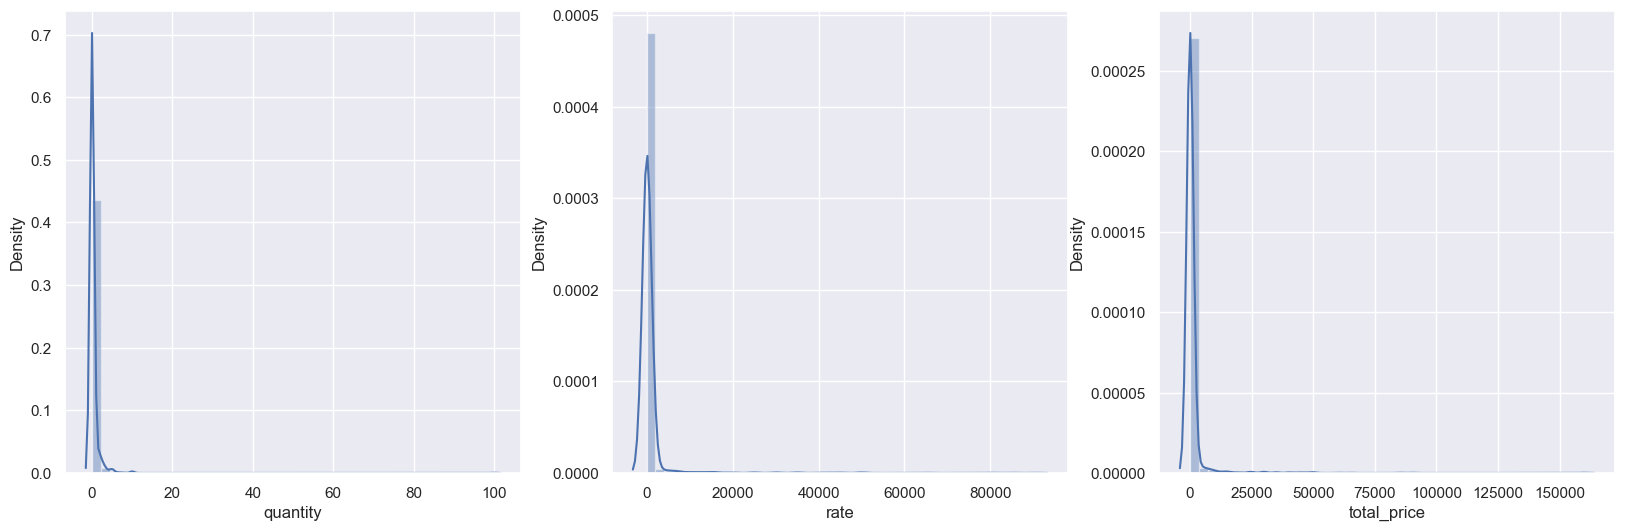

In [21]:
plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(df1["quantity"])

plt.subplot(132)
sns.distplot(df1["rate"])

plt.subplot(133)
sns.distplot(df1["total_price"])

plt.subplots_adjust(wspace = 0.2)

Let's see how the distribution is without the value zero.

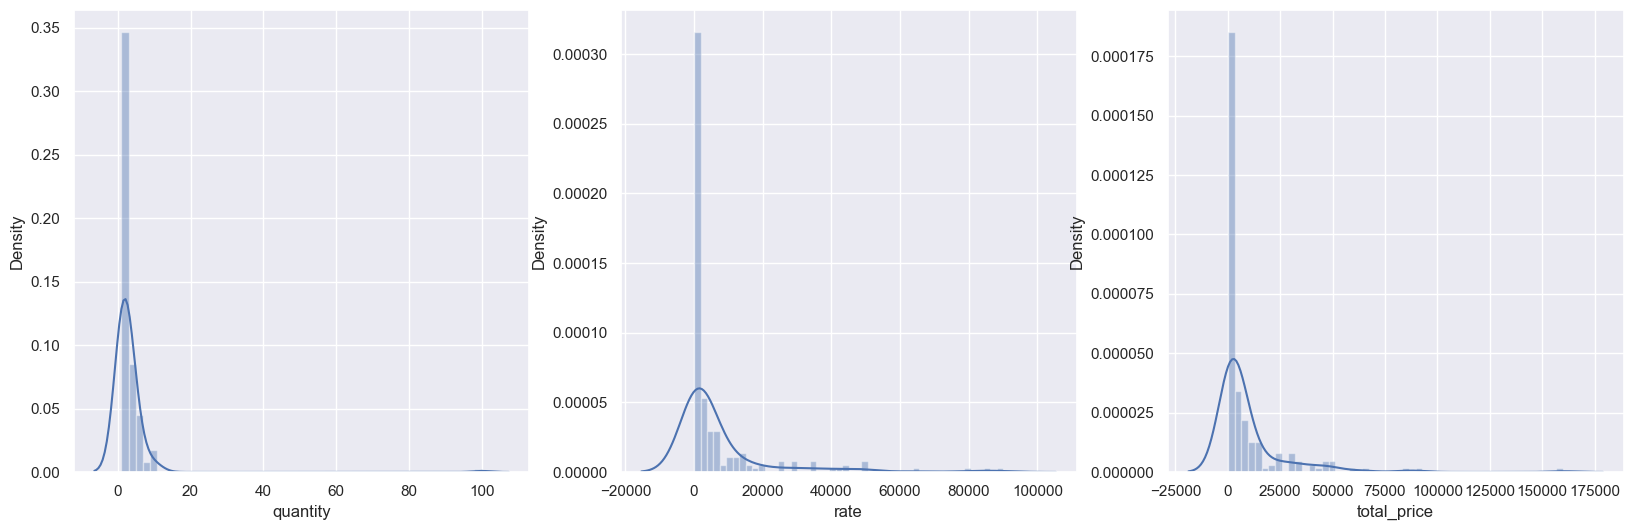

In [22]:
aux = df1[df1["quantity"] != 0]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

The majority of purchases is around smaller values for quantity. The result is smaller values for rate and total price too. Let's try to filter the columns again.

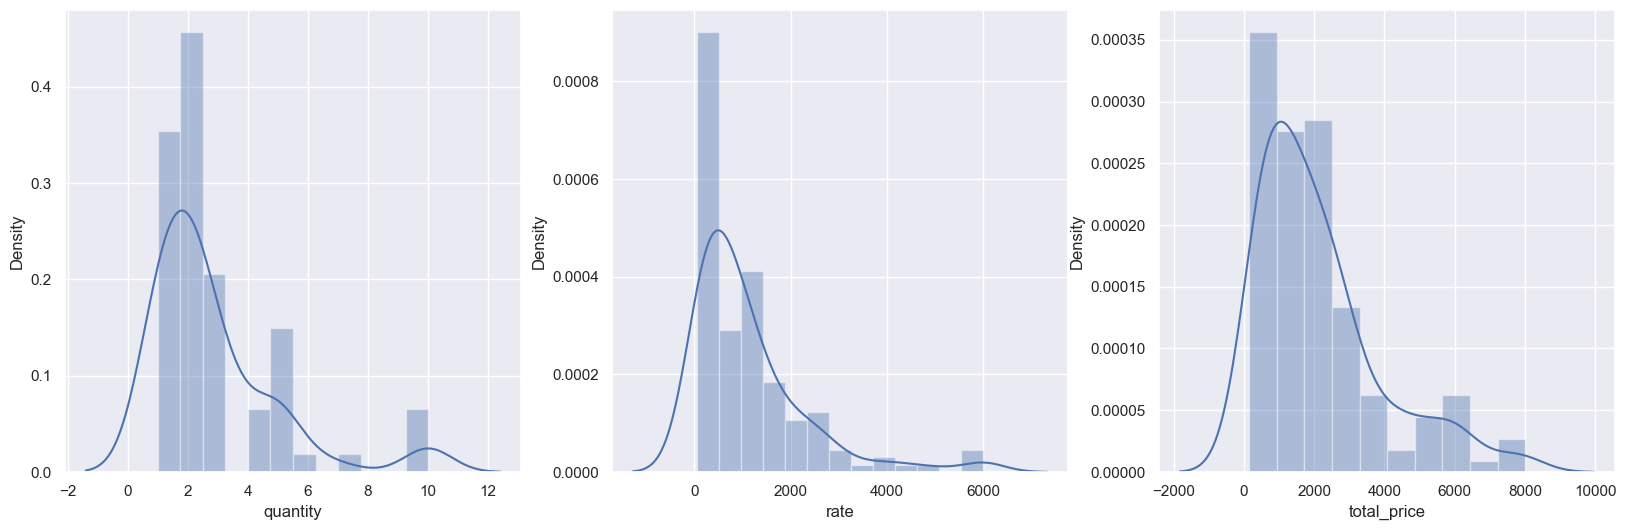

In [127]:
aux = df1[(df1["quantity"] != 0) & (df1["quantity"] < 100) & (df1["rate"] <= 6000) 
          & (df1["total_price"] <= 8000)]

plt.figure(figsize = (20,6))

plt.subplot(131)
sns.distplot(aux["quantity"])
#plt.xlim(0,)

plt.subplot(132)
sns.distplot(aux["rate"])
#plt.xlim(0,)

plt.subplot(133)
sns.distplot(aux["total_price"])
#plt.xlim(0,)

plt.subplots_adjust(wspace = 0.2)

- Now we see a left skew for the three features (positive skewness).
- We see a high kurtosis for quantity.
- We will keep this filter conditions in order to filter outliers rows in the next steps.

### 1.7.2. Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

category        105
sub_category    364
action           13
dtype: int64

In [24]:
cat_attributes.apply(lambda x: x.unique())

category        [Electronic Appliances, Men's Fashion, Mobile ...
sub_category    [Speakers, Jeans, Mobile, Cleaning sprays, Cha...
action          [first_app_open, search, product_view, read_re...
dtype: object

In [25]:
cat_attributes["category"].unique()

array(['Electronic Appliances', "Men's Fashion", 'Mobile & Accessories',
       'Cleaning supplies', 'Digital Devices', 'Accessories',
       'Stationary', 'Digital Content', 'Fitness', "Women's Fashion",
       'Household Supplies', 'Smart Wearables', 'Appliances', 'Pet Care',
       'Gardern and Outdoor', 'Camera Accessories', 'eCommerce',
       'Baby Care', 'Gaming Accessories', 'Musical Instruments',
       'Kitchen Appliances', 'Home Appliances', 'Entertainment Systems',
       'Software', 'Pendrives', 'Home Decor', 'Digital Appliances',
       'Electrical tools', 'Large appliances', 'Furnitures',
       'Religious items', 'Artwork', 'Baby Products', 'Car Accessories',
       "Kid's fashion", 'Motorbike Accessories', 'Toys', 'Music',
       'Music\n', 'Gifts', 'Tv and Appliances', 'Bags and Luggage',
       'Large Appliances', 'Industrial', 'Gardening', 'Grocery',
       'Winter Wear', 'Personal Care', "Men's Bottom Wear",
       "Men's Top Wear", 'Shoe care', 'Computer Periphera

In [26]:
cat_attributes["sub_category"].unique()

array(['Speakers', 'Jeans', 'Mobile', 'Cleaning sprays', 'Charging wire',
       'Kindle eBook', 'Watches', 'Cases', 'Books', 'Headphones',
       'Mouse pad', 'Fire Tv', 'Dumbells', 'Ethnic wear', 'Tws earbuds',
       'Cases and Covers', 'Shirts', 'Gloves', 'Dishwasher', 'Bumpers',
       'Denim jeans', 'Smart watches', 'Makeup kit', 'Ropes', 'Printers',
       'Shoes', 'Refrigerators', 'Harddisk', 'Cat food', 'Footwears',
       'Skipping Rope', 'Flower pot', 'Lens', 'Fire TV', 'Oil can',
       'Suspenders', 'Bow tie', 'Paints', 'Ear rings', 'Belt',
       'Frying pan', 'Rice cooker', 'CD-Driver', 'Bangles', 'Powerbells',
       'T-shirt', 'Container', 'Weigh scale', 'Tablet holder', 'Ring',
       'Tops', 'Charger', 'wrist band', 'Delivery bags', 'Women Jacket',
       'Water hose pipe', 'Coolers', 'Baby lotion', 'Aux Cable',
       'USB Cord', 'fitband', 'Screen Guard', 'laptop', 'Web camera',
       'Joystick', 'Tripods', 'Flute', 'Lamp', 'Surround system',
       'Pen stand', '

In [27]:
cat_attributes["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review',
       'add_to_wishist', 'read_review'], dtype=object)

In [28]:
cat_attributes.describe().T

,count,unique,top,freq
category,2090,105,Mobile & Accessories,139
sub_category,2090,364,Books,46
action,2090,13,read_reviews,342


### 1.7.3. Data Cleaning for Categorical Attributes

We must perform a categorical cleaning, since we have uppercase and words separated by spaces, and special char for the columns category and sub_category.

In [72]:
# category
df1['category'] = df1['category'].apply(lambda x: x.replace(' ', '_').\
                                        replace('\n', '').replace("'s", '').replace("&", "and").lower())

# sub_category
df1['sub_category'] = df1['sub_category'].apply(lambda x: x.replace(' ', '_').\
                                                replace("'s", '').replace("-", '_').lower())     

df1['action'] = df1['action'].apply(lambda x: 'read_reviews' if x in ('read_review') else x)
df1['action'] = df1['action'].apply(lambda x: 'add_to_wishlist' if x in ('add_to_wishist') else x)

In [73]:
df1["category"].unique()

array(['electronic_appliances', 'men_fashion', 'mobile_and_accessories',
       'cleaning_supplies', 'digital_devices', 'accessories',
       'stationary', 'digital_content', 'fitness', 'women_fashion',
       'household_supplies', 'smart_wearables', 'appliances', 'pet_care',
       'gardern_and_outdoor', 'camera_accessories', 'ecommerce',
       'baby_care', 'gaming_accessories', 'musical_instruments',
       'kitchen_appliances', 'home_appliances', 'entertainment_systems',
       'software', 'pendrives', 'home_decor', 'digital_appliances',
       'electrical_tools', 'large_appliances', 'furnitures',
       'religious_items', 'artwork', 'baby_products', 'car_accessories',
       'kid_fashion', 'motorbike_accessories', 'toys', 'music', 'gifts',
       'tv_and_appliances', 'bags_and_luggage', 'industrial', 'gardening',
       'grocery', 'winter_wear', 'personal_care', 'men_bottom_wear',
       'men_top_wear', 'shoe_care', 'computer_peripherals', 'health',
       'laptop_accessories', 'l

In [74]:
df1["sub_category"].unique()

array(['speakers', 'jeans', 'mobile', 'cleaning_sprays', 'charging_wire',
       'kindle_ebook', 'watches', 'cases', 'books', 'headphones',
       'mouse_pad', 'fire_tv', 'dumbells', 'ethnic_wear', 'tws_earbuds',
       'cases_and_covers', 'shirts', 'gloves', 'dishwasher', 'bumpers',
       'denim_jeans', 'smart_watches', 'makeup_kit', 'ropes', 'printers',
       'shoes', 'refrigerators', 'harddisk', 'cat_food', 'footwears',
       'skipping_rope', 'flower_pot', 'lens', 'oil_can', 'suspenders',
       'bow_tie', 'paints', 'ear_rings', 'belt', 'frying_pan',
       'rice_cooker', 'cd_driver', 'bangles', 'powerbells', 't_shirt',
       'container', 'weigh_scale', 'tablet_holder', 'ring', 'tops',
       'charger', 'wrist_band', 'delivery_bags', 'women_jacket',
       'water_hose_pipe', 'coolers', 'baby_lotion', 'aux_cable',
       'usb_cord', 'fitband', 'screen_guard', 'laptop', 'web_camera',
       'joystick', 'tripods', 'flute', 'lamp', 'surround_system',
       'pen_stand', 'mcafee_prot

In [75]:
df1["action"].unique()

array(['first_app_open', 'search', 'product_view', 'read_reviews',
       'add_review', 'add_to_cart', 'checkout', 'purchase',
       'add_to_wishlist', 'click_wishlist_page', 'product_review'],
      dtype=object)

### 1.7.4. Correlation Matrix

Cramer's V method to evaluate correlation between categorical attributes.

In [76]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

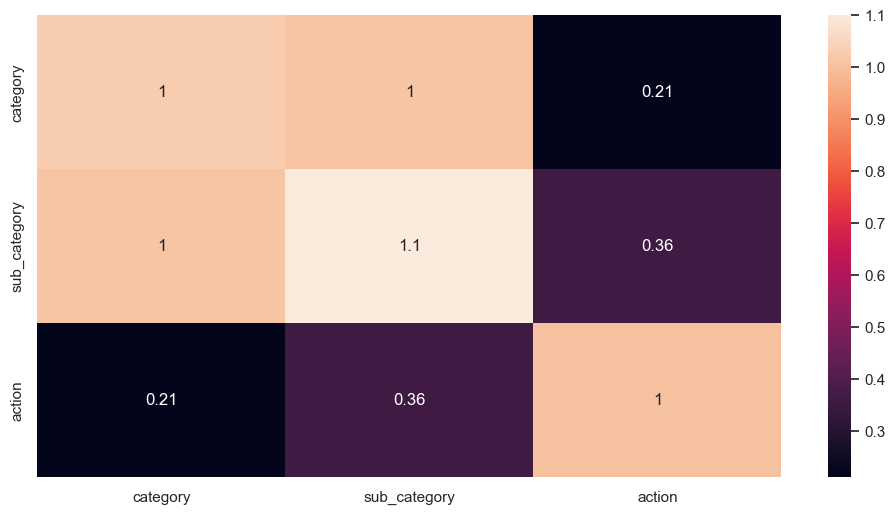

In [77]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

- The maximum correlation value should be 1. Yet, sub_category is 1.1 correlated with sub_category. Since this happened for the same column, we are just going to consider this value as 1.
- category and sub_category are high correlated. Since we have much more unique values for sub_category (section 1.7.2), we are going to remove category column in the section 3.

# 2. Feature Engineering

In [78]:
df2 = df1.copy()

In [79]:
df2.dtypes

user_id                  int64
session_id              object
date_time       datetime64[ns]
category                object
sub_category            object
action                  object
quantity               float64
rate                   float64
total_price            float64
dtype: object

In [80]:
df2.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.0,0.0,0.0
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.0,0.0,0.0
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.0,0.0,0.0
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.0,0.0,0.0
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.0,0.0,0.0


In [81]:
# year 
df2['year'] = df2['date_time'].dt.year

# month  
df2['month'] = df2['date_time'].dt.month

# day  
df2['day'] = df2['date_time'].dt.day

# day of week  
df2['day_of_week'] = df2['date_time'].dt.dayofweek

# week of year  
df2['week_of_year'] = df2['date_time'].dt.weekofyear

In [82]:
df2.shape

(2090, 14)

# 3. Feature Filtering and Selection

We are going to filter rows and select columns based on the previous data description section. 

In [128]:
df3 = df2.copy()

## 3.1. Feature Filtering

Removing outliers based on 75 percentile. 

In [129]:
df3 = df3[(df3["quantity"] < 100) & (df3["rate"] <= 6000) 
          & (df3["total_price"] <= 8000)]

## 3.2. Columns Selection

Based on the section 1.7.4, we chose the category column to be removed. We must have the minimum number of columns which describe the same phenomenon in the model in order to avoid overfitting.

In [130]:
cols_drop = ["category"]
df3 = df3.drop(cols_drop, axis=1)

In [131]:
df2.shape

(2090, 14)

In [132]:
df3.shape

(2032, 13)

# 4. Exploratory Data Analysis (EDA)

The main objectives of this section is:

- To acquire business experience from data.
- To generate insights to the business team.
- To evaluate features impact over the phenomenon.

In [85]:
df4 = df2.copy()

In [86]:
df4.head()

,user_id,session_id,date_time,category,sub_category,action,quantity,rate,total_price,year,month,day,day_of_week,week_of_year
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,electronic_appliances,speakers,first_app_open,0.0,0.0,0.0,2019,1,10,3,2
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,electronic_appliances,speakers,search,0.0,0.0,0.0,2019,1,10,3,2
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,men_fashion,jeans,search,0.0,0.0,0.0,2019,1,10,3,2
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,men_fashion,jeans,product_view,0.0,0.0,0.0,2019,1,10,3,2
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,men_fashion,jeans,read_reviews,0.0,0.0,0.0,2019,1,10,3,2


## 4.1. Univariate Analysis

In [56]:
profile = ProfileReport(df4, title='Customer Propensity to Purchase')
profile.to_file(output_file='customer_propensity_purchase_statistics_after_cleaning.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We found that the columns quantity, rate and total_price are high correlation with each other. We are going to better analyze before deciding remove each of them.

In [87]:
# Timerange of data
print("Min Date: " +str(df4.date_time.min()))
print("Max Date: " +str(df4.date_time.max()))
print("Range: " +str(df4.date_time.max()-df4.date_time.min()))

Min Date: 2019-01-01 11:00:00
Max Date: 2019-12-22 17:52:00
Range: 355 days 06:52:00


In [124]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df4[df4["quantity"] > 0].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,201.00,53901272628.92,2816738504.08,51448162784.00,51725305614.00,52313781035.00,55538327311.00,60302643179.00
quantity,201.00,2.97,7.16,1.00,1.00,2.00,3.00,100.00
rate,201.00,7133.28,14778.15,10.00,500.00,1200.00,6000.00,90000.00
total_price,201.00,9455.37,18213.70,150.00,1000.00,2500.00,8000.00,160000.00
year,201.00,2019.00,0.00,2019.00,2019.00,2019.00,2019.00,2019.00
month,201.00,8.29,3.04,1.00,6.00,10.00,10.00,12.00
day,201.00,14.15,6.18,1.00,11.00,11.00,17.00,31.00
day_of_week,201.00,2.32,1.89,0.00,0.00,2.00,4.00,6.00
week_of_year,201.00,34.27,13.31,2.00,24.00,41.00,44.00,51.00


The three variables have the same count. We may not choose any variable based on a minor count though.

Total Unique Categories: 101


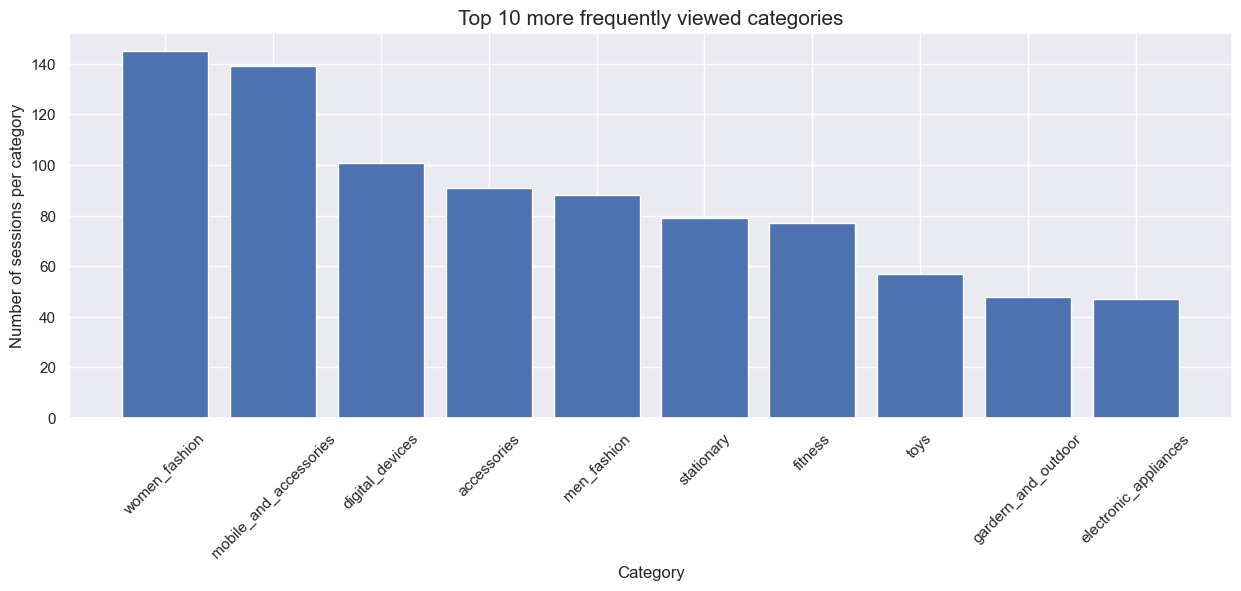

In [89]:
# Distribution of Category
print("Total Unique Categories: " + str(df4.category.nunique()))
temp_category = df4.groupby('category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_category.category, temp_category.session_id)
plt.title("Top 10 more frequently viewed categories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of sessions per category")
plt.show()

Total Unique SubCategories: 358


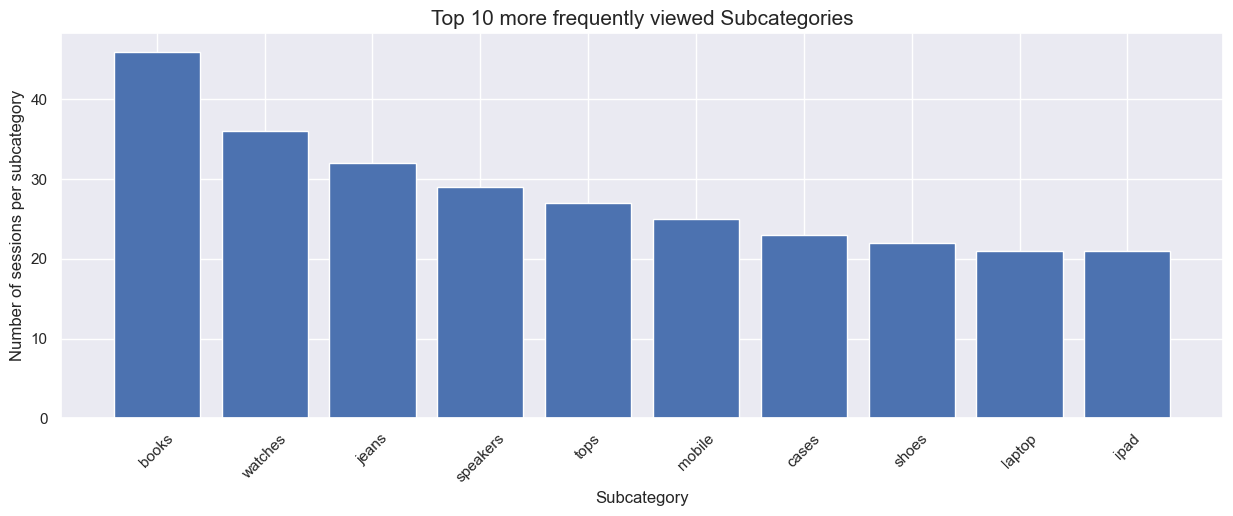

In [90]:
# Distribution of SubCategory
print("Total Unique SubCategories: " + str(df4.sub_category.nunique()))
temp_subcategory = df4.groupby('sub_category')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_subcategory.sub_category, temp_subcategory.session_id)
plt.title("Top 10 more frequently viewed Subcategories", size=15)
plt.xticks(rotation=45)
plt.xlabel("Subcategory")
plt.ylabel("Number of sessions per subcategory")
plt.show()

read_reviews           343
search                 320
product_view           292
add_to_cart            280
checkout               202
click_wishlist_page    202
purchase               201
first_app_open         121
add_review              69
add_to_wishlist         38
product_review          22
Name: action, dtype: int64

Total Unique Actions: 11


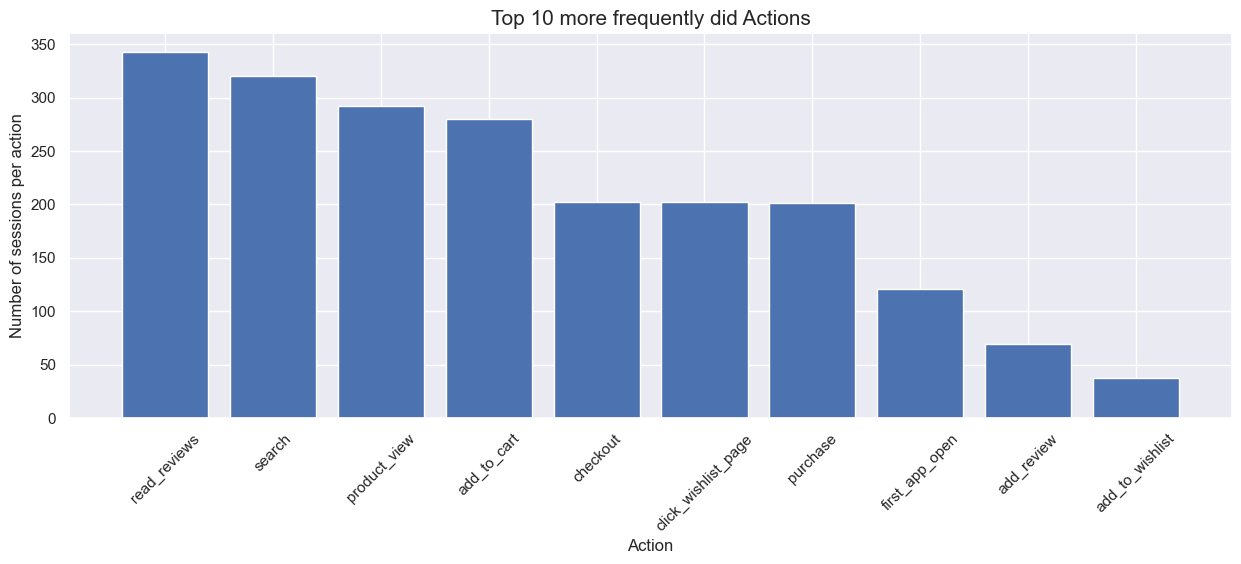

In [95]:
# Distribution of Action
display(df4.action.value_counts())

print("Total Unique Actions: " + str(df4.action.nunique()))
temp_actions = df4.groupby('action')['session_id'].count().sort_values(ascending=False).reset_index()[:10]

plt.figure(figsize=(15,5))
plt.bar(temp_actions.action, temp_actions.session_id)
plt.title("Top 10 more frequently did Actions", size=15)
plt.xticks(rotation=45)
plt.xlabel("Action")
plt.ylabel("Number of sessions per action")
plt.show()

## 4.2 Bivariate Analysis

We are going to perform bivariate analysis in order evaluate how the features are correlated with the target variable.

Based on the initial understanding of the different columns in the data (univariate analysis), we can create some hypothesis (if any) or try to ask more complex questions such as:

1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?
2. Which is the most purchased Category/Sub-category?
3. Do people add the products to cart before they purchase or buy directly?
4. What is the average time taken by a user to buy a product?
5. What is the average time between repeat purchase?
6. What is the trend of unique users across the time period?
7. What is the trend of purchase across the time period?
8. This is not the exhaustive list but good to start with.

#### 1. How many unique users in the data and how many of them purchased at least once? Also, what is the average number of purchase per customer?

The "agg" function in Python: this is typically used to aggregate data in a DataFrame. Specifically, it is counting the number of rows in the "sub_category" column of the DataFrame. As we are filtering the sub_category "purchase", we see the number of rows for purchase. The result of this function would be a single value representing the count of rows in the "sub_category" column equals to "purchase". As we grouped by user_id before, thus the result is the number of purchase rows per user_id (an average value). 

In [138]:
# unique customers 
total_users = df4.user_id.nunique()
print(f"Total customers: {total_users}.")

# at least 1 purchase customer
atleast_one_purchase_cust = df4[df4['action']=='purchase']['user_id'].nunique()
conversion = 100*round(atleast_one_purchase_cust/total_users, 2)
print(f"Customers who made at least 1 purchase: {atleast_one_purchase_cust} ({conversion}% conversion)")

# avg purchase per customer
purch_dist_by_cust = (df4[df4['action']=='purchase'].groupby('user_id').agg({'sub_category': 'count'})
                      .reset_index().sort_values(by='sub_category', ascending=False) # True or False
                     )
purch_dist_by_cust.rename(columns={'sub_category':'number_of_purchase'}, inplace=True)

print(f"Average number of purchase per customer: {round(purch_dist_by_cust.number_of_purchase.mean(), 2)}")

print("\nDistribution of Number of Purchases:")
display(purch_dist_by_cust[['number_of_purchase']].describe())

Total customers: 401.
Customers who made at least 1 purchase: 167 (42.0% conversion)
Average number of purchase per customer: 1.2

Distribution of Number of Purchases:


,number_of_purchase
count,167.00
mean,1.20
std,0.43
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,3.00
